In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [2]:
# Define Paths
base_path = "/content/drive/MyDrive/GAN-BarlowTwins"
script_path = f"{base_path}/STGAN-Finetune-BarlowTwins"
image_root = f"{base_path}/training_images"
csv_path = f"{base_path}/ISIC2018_Task3_Training_GroundTruth.csv"
pretrained_ckpt = f"{base_path}/all_70000.pth"
checkpoints = f"{base_path}/checkpoints"
temp_gen_dir = f"{base_path}/generated_temp"
real_df_dir = f"{base_path}/df_real_images"

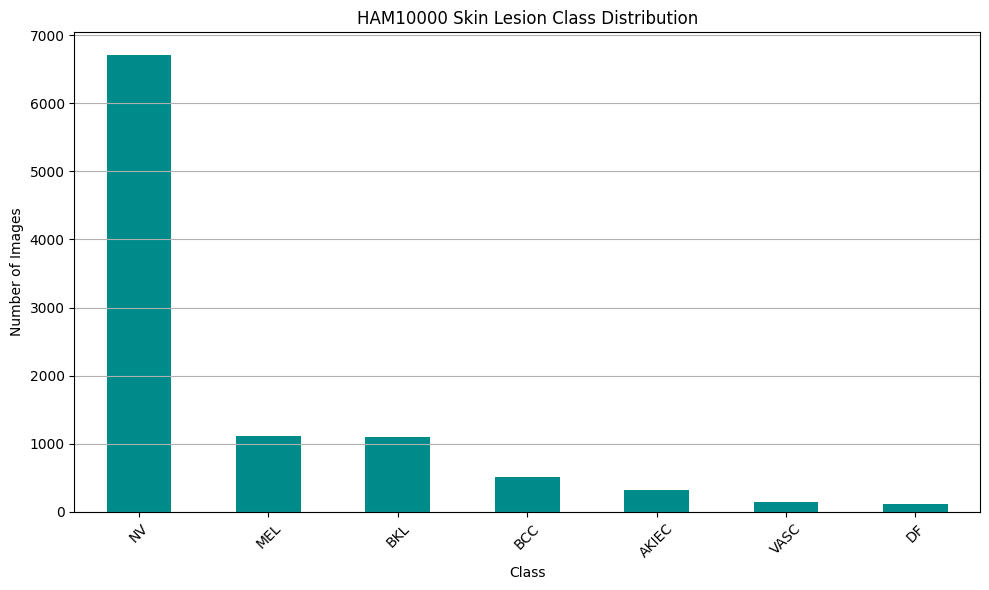

In [3]:
# Class Distribution in HAM10000
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(csv_path)

# Count number of samples for each class (sum of one-hot encoded columns)
class_counts = df.iloc[:, 1:].sum().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='darkcyan')
plt.title("HAM10000 Skin Lesion Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Check data fo NAs
import os

# Load label file
df = pd.read_csv(csv_path)

# Filter for DF class (one-hot encoded)
df_df = df[df["DF"] == 1.0].copy()
print(f"Total DF samples in CSV: {len(df_df)}")

# Build full image paths and verify they exist
df_df["image_path"] = df_df["image"].apply(lambda x: os.path.join(image_root, f"{x}.jpg"))
df_df = df_df[df_df["image_path"].apply(os.path.exists)].reset_index(drop=True)

print(f"Valid image files found: {len(df_df)}")
df_df.head()

Total DF samples in CSV: 115
Valid image files found: 115


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,image_path
0,ISIC_0024318,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
1,ISIC_0024330,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
2,ISIC_0024386,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
3,ISIC_0024396,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...
4,ISIC_0024553,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/content/drive/MyDrive/GAN-BarlowTwins/trainin...


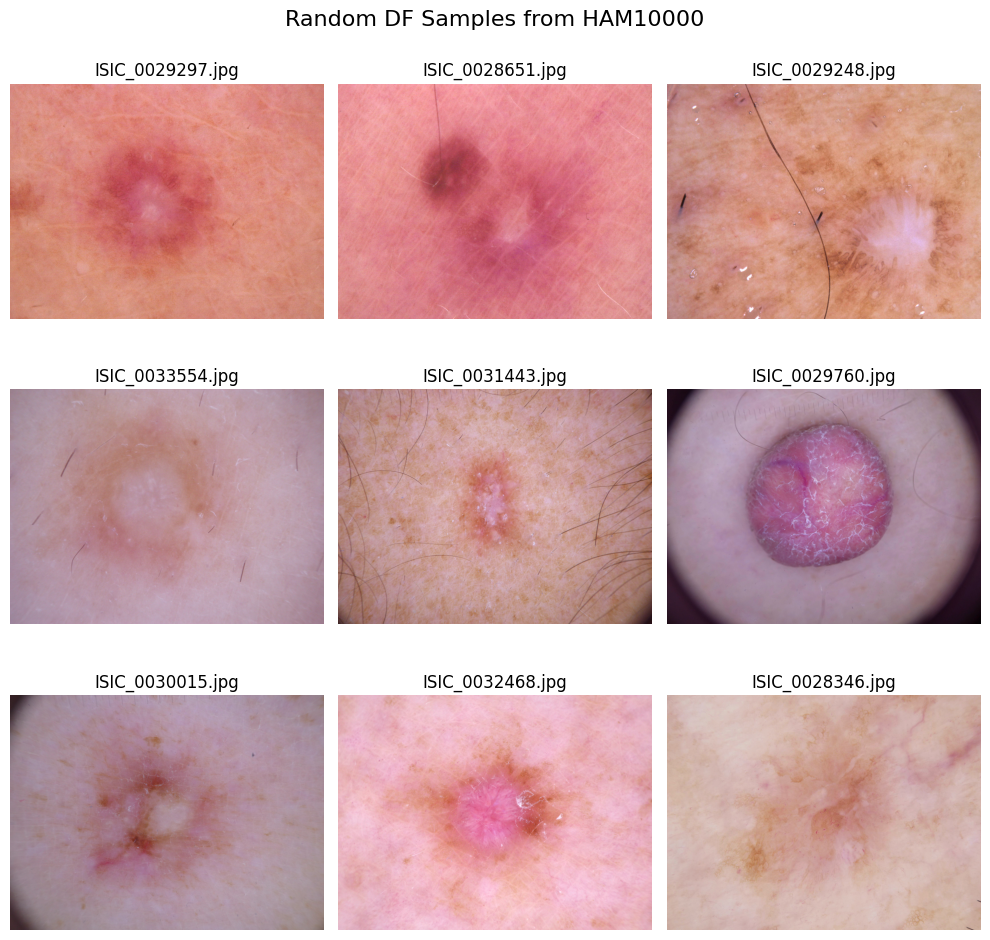

In [5]:
# Plot a Few Random DF Samples
from PIL import Image
import random

# Select a few random samples
sample_paths = random.sample(list(df_df["image_path"]), 9)

# Plot them
plt.figure(figsize=(10, 10))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(path))
    plt.axis("off")

plt.suptitle("Random DF Samples from HAM10000", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# Prepare dataframe
import pandas as pd
import os

# Load and filter for any class (e.g., 'DF' == 1.0)
df = pd.read_csv(csv_path)
df_df = df[df['DF'] == 1.0].copy()

# Construct full image paths
df_df["image_path"] = df_df["image"].apply(lambda x: os.path.join(image_root, f"{x}.jpg"))

# Save to CSV to use with your script
df_df.to_csv("df_filtered.csv", index=False)

In [7]:
# Create a folder with real DF images to evaluate generated images
import shutil
from tqdm import tqdm

# Path to new real DF directory
real_df_dir = os.path.join(base_path, "df_real_images")
os.makedirs(real_df_dir, exist_ok=True)

# Copy each DF image to that directory
for src_path in tqdm(df_df["image_path"], desc="Copying DF images"):
    shutil.copy(src_path, real_df_dir)

Copying DF images: 100%|██████████| 115/115 [00:38<00:00,  2.96it/s]


Load Model and Train

In [8]:
# Add script to the environment
import sys
sys.path.append(script_path)

# Import modules
from stgan_models_finetune import Generator, Discriminator
from stgan_train_finetune import train

In [9]:
# Run training
!python {script_path}/stgan_train_finetune.py \
  --csv_path df_filtered.csv \
  --image_root {image_root} \
  --ckpt {pretrained_ckpt} \
  --iter 1000 \
  --batch_size 8 \
  --im_size 256 \
  --lr 1e-4 \
  --ckpt_every 200

Loaded pretrained weights from /content/drive/MyDrive/GAN-BarlowTwins/all_70000.pth
 20% 199/1000 [00:41<02:33,  5.21it/s]Iter [200] Loss_D: 1.8163, Loss_G: 0.0592, BT: 40874.4766, BT_λ: 0.00020, σ: 0.09800
[16:21:47] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_200.pth
 40% 399/1000 [01:38<01:55,  5.21it/s]Iter [400] Loss_D: 1.7406, Loss_G: 0.1457, BT: 69627.5234, BT_λ: 0.00040, σ: 0.09600
[16:22:44] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_400.pth
 60% 599/1000 [02:35<01:16,  5.24it/s]Iter [600] Loss_D: 1.8906, Loss_G: -0.0320, BT: 86241.7031, BT_λ: 0.00060, σ: 0.09400
[16:23:40] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_600.pth
 80% 799/1000 [03:31<00:38,  5.20it/s]Iter [800] Loss_D: 1.6397, Loss_G: 0.0063, BT: 110684.9375, BT_λ: 0.00080, σ: 0.09200
[16:24:37] Saved checkpoint: /content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_800.pth
100% 999/1000 [04:28<00:00,  5.26it/s]Iter [1000] 

In [10]:
!pip install pytorch-fid clean-fid torch-fidelity lpips --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00


In [11]:
!python {script_path}/eval.py \
  --ckpt_dir {checkpoints} \
  --real_dir {real_df_dir} \
  --temp_gen_dir {temp_gen_dir} \
  --n_samples 115 \
  --eval_every 200

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:01<00:00, 224MB/s]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating Checkpoints:   0% 0/6 [00:00<?,

In [17]:
# Image Generator

import os
import torch
from torchvision import transforms
from torchvision.utils import save_image
from stgan_models_finetune import Generator
from tqdm import tqdm

def generate_images_from_ckpt(ckpt_path, out_dir, n_images, batch_size=50, nz=256, im_size=256):
    import os
    import torch
    from torchvision.utils import save_image
    from torchvision import transforms
    from stgan_models_finetune import Generator

    device = torch.device("cpu")  # Stay safe from cuDNN crash
    os.makedirs(out_dir, exist_ok=True)

    # Load Generator
    netG = Generator(nz=nz, im_size=im_size).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    g_weights = {k.replace("module.", "").replace("to_128", "to_rgb").replace("to_big", "to_rgb"): v for k, v in ckpt["g"].items()}
    netG.load_state_dict(g_weights, strict=False)
    netG.eval()

    # Generate images with progress bar
    with torch.no_grad():
        generated = 0
        with tqdm(total=n_images, desc="Generating images") as pbar:
            while generated < n_images:
                b = min(batch_size, n_images - generated)
                z = torch.randn(b, nz).to(device)
                imgs = netG(z).add(1).mul(0.5).clamp(0, 1)
                for i in range(b):
                    save_image(imgs[i], os.path.join(out_dir, f"{generated + i:05d}.png"))
                generated += b
                pbar.update(b)

    print(f" Generated {n_images} images to: {out_dir}")

In [20]:
# Customize for this class
class_name = "Dermatofibroma"
real_count = 115
target_count = 6705
ckpt_path = "/content/drive/MyDrive/GAN-BarlowTwins/checkpoints/ckpt_400.pth"
output_dir = f"/content/drive/MyDrive/GAN-BarlowTwins/synthetic_balanced/{class_name}"

In [21]:
images_to_generate = target_count - real_count
generate_images_from_ckpt(ckpt_path, output_dir, n_images=images_to_generate)

Generating images: 100%|██████████| 6590/6590 [13:30<00:00,  8.13it/s]

 Generated 6590 images to: /content/drive/MyDrive/GAN-BarlowTwins/synthetic_balanced/Dermatofibroma
